## EmbDI: weights on edges, is it worth the effort? 
In other posts (either already published, or existing only in my mind), we discussed what random walks are, how they can be built in some simple examples, and what they look like on EmbDI's graph. 

In this post, we will delve a bit deeper in how the random walks can be "piloted" to an extent, by adding weights to the edges. 

I will introduce a few functions that I developed to assign weights to the edges, then potentially run a few simulation of what the random walks generated with the different methods would look like. 

First off, some plumbing. Libraries and whatnot.  

In [6]:
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib as mpl


Setting the plot style so that it's not quite as cramped, and fixing the `facecolor` so that the plot will have white backgrounds even on dark themes. 

In [41]:
plt.style.use('fivethirtyeight')
# Setting the background color to white to avoid issues with dark themes
mpl.rcParams['axes.facecolor']='white'


## The functions
Now that the plumbing is done, let's talk about weight functions. 

Very broadly, a weight function $f(x)$ will assign a given weight $y \in [0, 1]$ to an edge, with $x$ being some value. In all the following examples, $x$ is the *degree of the cell node I am on*. 

So, before even starting to assign a weight, a counting operation is executed on the graph: at the end of this counting operation, we will have a list with all the nodes, and their degree. 

In EmbDI, all nodes are connected with bi-directional edges, which makes it possible to have different weights depending on the direction of the edge. For example, an edge $RID \rightarrow Value$ can have a different weight than the corresponding $Value \rightarrow RID$. In practice, this is implemented by assiging all $RID \rightarrow Value$ edges the same weight of $1.0$, while weights $Value \rightarrow RID$ receive a specific weight according to the functions I will be describing below. 

### Why should the edges be weighted? 
One of the main issues I have observed while working with EmbDI is the fact that high-degree nodes are frequent, and very disruptive. By virtue of their degree, they are connected to a huge number of additional nodes, so it is very likely that a random walk will encounter one such node very often. The final result is that the very frequent nodes will be overrepresented in the word2vec training corpus, while rare values will instead appear extremely rarely overall. 

Weights should counteract this behavior: by assigning a lower weight to high degree nodes, it becomes less likely to end in one, and rarer values are comparatively more likely to be chosen. As a result, the content of the training corpus becomes more "balanced", and thus improve the performance on the final task.

Now, all this is something that was tested to an extent during my PhD. However, at some point we observed that simple, unweighted random walks would work "just fine" in most cases, while choosing the best combination of parameters for the functions described below was normally not worth the effort. In the end, we never had the chance of testing some of the hypotheses I am taking there as assumptions: my plan is exploring those hypotheses in a few posts here.

In [42]:
# Defining functions

# No smoothing
def f1():
    return 1.0

# Smoothing with targeted exponential
def f2(x, eps=0.01, target=10, k=0.5):
    t = (eps / (1 - k)) ** (1 / (1 - target))
    y = (1 - k) * t ** (-x + 1) + k
    return y

# Smoothing with inverse weight
def f3(x, s):
    y = 1 / 2 * (-(1 + s) ** (1 - x) + 2)
    return y

# Weights inversely proportional to frequency
def f4(freq):
    return 1 / freq

# Weights inversely proportional to frequency, smoothed via log
def f5(freq):
    return 1 / (np.log10(freq) + 1)

### No smoothing
The first (and simplest) function that could be used to assign a weight is: don't assign a weight! By returning a fixed value of 1.0 for any node degree, no bias is introduced in the edges. This means that very frequent edges will, by nature, be selected more often overall than less frequent edges. This approach has the advantage of not requiring any type of parameter tuning of any kind, therefore simplifiyng the task of deciding what parameters to use. 
$$f_1(x) = 1$$


### Smoothing with targeted exponential
On the opposite end of the spectrum when it comes to complexity and number of parameters, $f_2(x)$ assignes a weight based on the degree of the node, while satisfying two additional requirements: the minimum weight that can be assigned to a node is guaranteed to be $k \in [0,1]$, and nodes with degree > $\tau$ will be guaranteed to be assigned a weight that is no more than $k + \epsilon$. 

With this function, all nodes with degree > 1 will receive a weight lower than 1. To avoid assiging weights that are so low, that the nodes would practically never be observed (see $f_4$ and the inverse frequency), a minimum weight of $k$ is guaranteed. By tuning the value of $\tau$, it is possible to select the degree at which nodes will receive the highest penalty: this parameter can be decided on the basis of the average degree of the graph.


$$f_2(x) = (1-k) \cdot t ^ {1-x} + k$$
where 
$$t = \frac{\epsilon}{1-k} ^ {\frac{1}{1-\tau}}$$


### Inverse smoothing
With $f_3#, I went in the opposite direction: what will happen if I assign a lower weight to already rare nodes, and full weight to the frequent values? Intuitively, this should produce worse results than the previous solutions, but some experimental results suggested that this was not always the case. 

$$f_3(x) = \frac{1}{2(-(1+s)^{1-x}) + 2}$$

$s$ is the slope of the exponential, and can be tweaked so that the curve increases more slowly. As it will become clear from the plot, the value of $s$ should be kept very low to have an impact on the growth. 

$f_3$ was supposed to be the (not mathematical) inverse of $f_2$, with a minimum weight given to the rarest values, which would then increase to 1.0 for the values whose frequency was larger than a given target. Unfortunately, I was not able to build it in the proper way, so I ended up with the function reported here, in which the slope $s$ decides how quickly does the weight increase. This is a sub-optimal solution that might be worth studying again at some point. 

### Weights inversely proportional to the node frequency
The last two functions I have looked into assign weights inversely proportional to the degree of the node, but with simpler functions compared to $f_2$. 

$$f_4(x) = \frac{1}{x}$$

$$f_5(x) = \frac{1}{log_{10}(x)+1}$$

Specifically, $f_4$ assigns its weight as a simple fraction. As I mentioned before, however, this means that, even for low degrees, the practical likelihood of selecting a node is quite small. For this reason, $f_5$ uses a $log$ function to have a slower decrease in the weight, at least for the earlier nodes. Depending on the base of the log, it is possible to tweak how quickly the curve decreases.  

## Plotting the results
Now that the functions have been described, I'll set up some examples to show how weights would be assigned. To do so, I define the variables `test_frequencies_linear` and `test_frequencies_log` as "dummy counts" for the degree of the nodes. Indeed, the logspace is more useful for huge graphs, which we aren't considering here, so I will use `test_frequencies_linear` in all plots. 

In [43]:
# Defining x axes
test_frequencies_linear = np.arange(1,10000,1)
test_frequencies_log = np.logspace(0, 4)

In [44]:
# The plotting function, with some additional parameters to save some effort. 
def plot_with_params(ax, x, y, x_point=None, y_point=None, title=None, xlim=None, label=None):
    """This is a simple plotting function that produces a lineplot with some given parameters.

    Args:
        ax (plt.Axes): Axes object to use to plot the data.
        x (np.array): X-axis values
        y (np.array): Y-axis values
        x_point (float, optional): If provided, x-axis of a single point to highlight on the plot. Defaults to None.
        y_point (float, optional): If provided, y-axis of a single point to highlight on the plot. Defaults to None.
        title (str, optional): Title of the plot. Defaults to None.
        xlim (_type_, optional): If provided, the x-limits of the plot. Defaults to None.
        label (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    ax.plot(x, y)
    if all([x_point is not None, y_point is not None]):
        ax.plot(x_point, y_point, marker='o')
    ax.set_ylim([0, 1.1])
    if xlim is None:
        ax.set_xlim([0, max(x)])
    else:
        ax.set_xlim(xlim)
    ax.set_title(title)
    if label is not None:
        ax.set_label(label)
    return ax.get_legend_handles_labels

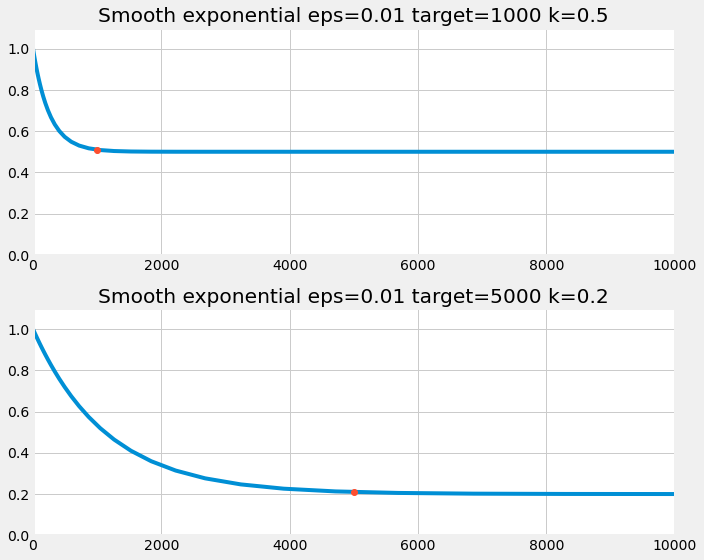

In [46]:
x = test_frequencies_log
fig, axs = plt.subplots(2, figsize=(10, 8))
ax1, ax2 = axs

# Target is the degree beyond which all values will have weight < k + eps
target = 1000
# An arbitrary small value
eps = 0.01
# The minimum weight
k = 0.5
y = f2(x, target=target, eps=eps, k=k)
y_tgt = f2(target, target=target, k=k, eps=eps)
title = f'Smooth exponential eps={eps} target={target} k={k}'

plot_with_params(ax1, x, y, target, y_tgt, title)

target = 5000
eps = 0.01
k = 0.2
y = f2(x, target=target, eps=eps, k=k)
y_tgt = f2(target, target=target, k=k, eps=eps)
title = f'Smooth exponential eps={eps} target={target} k={k}'

plot_with_params(ax2, x, y, target, y_tgt, title)

plt.tight_layout()


The two examples show that the function is working properly, and that it is possible to tune its behavior to a quite high degree. The red dots on the plot highlight the "limit" beyond which all values are assigned (approximately) the same weight. 

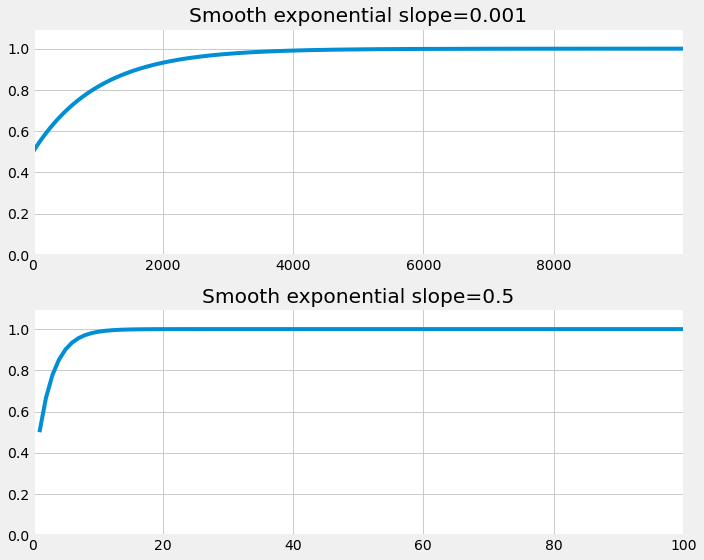

In [49]:
x = test_frequencies_linear
fig, axs = plt.subplots(2, figsize=(10, 8))
ax1, ax2 = axs

slope = 0.001
y = f3(x, slope)
title = f'Smooth exponential slope={slope}'

plot_with_params(ax1, x, y, title=title)

slope = 0.5
y = f3(x, slope)
title = f'Smooth exponential slope={slope}'

plot_with_params(ax2, x, y,  title=title, xlim=[0, 100])

plt.tight_layout()


As anticipated above, $f_3$ is not as tuneable as $f_2$, and the values of $s$ must be picked carefully. Even with a small value of $0.5$, weights reach the limit around degree 10. 

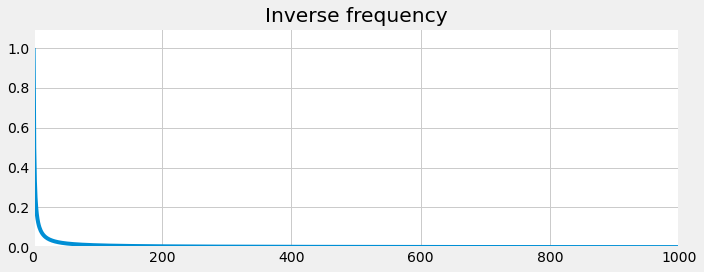

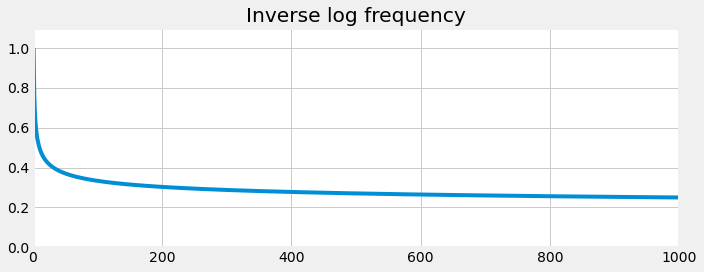

In [51]:
x = test_frequencies_linear
fig1, ax1 = plt.subplots(1, figsize=(10, 4))
slope = 0.01
y = f4(x)
title = f'Inverse frequency'
plot_with_params(ax1, x, y, title, xlim=[0,1000], title=title)
plt.tight_layout()
fig1.savefig(f'{title}.pdf')

x = test_frequencies_linear
fig2, ax1 = plt.subplots(1, figsize=(10, 4))
slope = 0.01
y = f5(x)
title = f'Inverse log frequency'
plot_with_params(ax1, x, y, title, xlim=[0, 1000], title=title)
plt.tight_layout()
fig2.savefig(f'{title}.pdf')

Finally, the two plots show the weights that are assigned according to the inverse of the frequency. Indeed, weights for frequent nodes become extremely small. Overall, high-degree nodes may still appear so frequently in the random walks that some kind of balance arises, however this should be tested. 

As expected, applying a `log` function to the frequency before the division takes place reduces a lot the steepness of the descent, which means that most frequency values will have a weight noticeable larger than 0. 

## Conclusions
I decided to write this post mostly as a reminder to myself of these functions, how they worked and what they looked like. I am planning to revisit the EmbDI code and run a few simulations on the sentence generation part, to get a more structured idea of the effect of the different functions on the overall distribution of values in the training corpus of the word2vec algorithm. 